# Initalize libaries and file name
## !!!(YOU NEED TO PIP INSTALL h5py)!!! "conda install h5py" in console

In [2]:
#Grab those libaries, I ain't writing shit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pathlib
from mpl_toolkits import mplot3d
from scipy.interpolate import splprep, splev
from scipy.integrate import quad
from scipy.ndimage import label
import matplotlib.colors as mcolors

import random
from statistics import mean
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm
#from matplotlib.mlab import griddata
from scipy import interpolate
import h5py

import scipy
from scipy import stats
import math
import time
import datetime

# GenZ does programming - replace all to undo it
yap = print
cap = False
noCap = True

#------------#------------#
# Font Settings
#------------#------------#

# Set global font to Times New Roman and font size to 10pt
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 10
plot_font_size = 20


#------------#------------#
# File Names and Paths
#------------#------------#


# Folder Name
xyz_folder_name = "A - 316L Rod"

# File Names
#sample_1_pre_test_name = 'A1 Pre-Galling Test.xyz'
sample_1_post_test_name = 'A1 Post-Galling Test.xyz'
#sample_2_pre_test_name = 'A2 Pre-Galling Test.xyz'
sample_2_post_test_name = 'A2 Post-Galling Test.xyz'

# Code File Location
code_dir = os.path.dirname("Profilometry Analysis Code - Kit")

# Source Files relative to code file
#csv_path_1_pre_test = os.path.join(code_dir,"..","xyz Files",xyz_folder_name,sample_1_pre_test_name)
csv_path_1_post_test = os.path.join(code_dir,"..","xyz Files",xyz_folder_name,sample_1_post_test_name)
#csv_path_2_pre_test = os.path.join(code_dir,"..","xyz Files",xyz_folder_name,sample_2_pre_test_name)
csv_path_2_post_test = os.path.join(code_dir,"..","xyz Files",xyz_folder_name,sample_2_post_test_name)

# Create the output file name based on the input file name
#output_sample_1_pre_test_name = sample_1_pre_test_name.replace('.xyz', '_piv.txt')
output_sample_1_post_test_name = sample_1_post_test_name.replace('.xyz', '_piv.txt')
#output_sample_2_pre_test_name = sample_2_pre_test_name.replace('.xyz', '_piv.txt')
output_sample_2_post_test_name = sample_2_post_test_name.replace('.xyz', '_piv.txt')

# Replace the file extension for the output CSV file
#saving_sample_1_pre_test_name = sample_1_pre_test_name.replace('.xyz', '_processed.h5')
saving_sample_1_post_test_name = sample_1_post_test_name.replace('.xyz', '_processed.h5')
#saving_sample_2_pre_test_name = sample_2_pre_test_name.replace('.xyz', '_processed.h5')
saving_sample_2_post_test_name = sample_2_post_test_name.replace('.xyz', '_processed.h5')


#------------#------------#
# Profilometer Scan Parameters
#------------#------------#

# These need to be defined based on resolution, and hence, predefined before running the rest of the code
X_res = None #um
Y_res = None #um
# Sample Shape
real_outer_radius = None
real_inner_radius = None
# Convert units from input units
unit_conversion_xy = None # convert to mm
unit_conversion_z = None # convert to um
# Column Separator
col_sep = None
# Metadata to skip
skip_rows = None

def set_parameters(file_path):
    
    def set_globals(first_line):
        global X_res, Y_res, real_outer_radius, real_inner_radius, unit_conversion_xy, unit_conversion_z, col_sep, skip_rows
        if first_line.startswith("Zygo"):
# Zugo Imperial College File Format
            X_res = 3.484
            Y_res = X_res
            real_outer_radius = 6.35
            real_inner_radius = 3.1875
            unit_conversion_xy = 1
            unit_conversion_z = 1
            col_sep = '\\s+' # treating multiple spaces as a single delimiter
            skip_rows = 14
        elif first_line.startswith("# Channel"):
# Bruker ContourX-100/200/500 Optical Profilometer with Vision64 software OPDX data convered to xyz via Gwyddion
            X_res = 2.576
            Y_res = X_res
            real_outer_radius = 6.35
            real_inner_radius = 3.21
            unit_conversion_xy = 1e3
            unit_conversion_z = 1e6
            col_sep = '\\s+' # treating multiple spaces as a single delimiter
            skip_rows = 3
        else:
            X_res = None
            Y_res = None
            real_outer_radius = None
            real_inner_radius = None
            unit_conversion_xy = None
            unit_conversion_z = None
            col_sep = None
            skip_rows = None
            raise ValueError("Unrecognised File MetaData")
            
            
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()
        set_globals(first_line)

# Set Parameters
set_parameters(csv_path_1_post_test)
yap('Check parameter selecetion, skip_rows = ', skip_rows)
        
# Size of Edge Effects
edge = 0.1 #distance (mm) from sample edges to be removed during tilt correction
yap('Edge size / mm: ', edge)
    
# Sample shape and resolution
mean_res = (X_res+Y_res)/2000 # in mm, potential for different resolution in X & Y
outer_radius = (real_outer_radius - edge)/mean_res # in px, the standard is 6.35 mm
inner_radius = (real_inner_radius + edge)/mean_res # in px, the standard is 3.1875 mm



Check parameter selecetion, skip_rows =  3
Edge size / mm:  0.1


# Process the code:
# 1 Converts raw data to a useful format
# 2 Removes and filters useless data
# 3 Interpolates missing data
# 4 Tilts surface
# 5 Translates mean height to 0

In [2]:
start_time = time.time()

def process_raw_data(file_path, output_file_name, saving_file_name):

#------------#------------#
# Step 0: Define Analysis Parameters
#------------#------------#

# Filtering parameters
    moving_average = 15 - 1 # must be even?????
    std_range = 1 #Number of standard deviations from mean which is accepted


# Min data points in a row/column for physical centre locating
    min_points = 250 # Minimum number of data points in a row/column that we'll consider as being a relevant row/column for calculating the mid-point


#------------#------------#
# Step 1: Read, convert, and save
#------------#------------#

# Read the CSV file
    unprocessed_data = pd.read_csv(file_path, sep=col_sep, skiprows=skip_rows, usecols=[0,1,2])
    yap('Read the CSV file')
    
# Remove last row (if erroneous)
    if not isinstance(unprocessed_data.iloc[-1, 0], (int, float)):
        unprocessed_data = unprocessed_data.iloc[:-1]
        
# Replace "No" with NaN
    if unprocessed_data.iloc[0,-1] == "No":
        unprocessed_data.replace("No", np.nan, inplace=noCap)
        
# Assuming the DataFrame has the structure [X, Y, Z]
    unprocessed_data.columns = ['X', 'Y', 'Z']  # Assign column names if needed
    unprocessed_data['X'] = unprocessed_data['X'].astype('float64') *unit_conversion_xy
    unprocessed_data['Y'] = unprocessed_data['Y'].astype('float64') *unit_conversion_xy
    unprocessed_data['Z'] = unprocessed_data['Z'].astype('float64') *unit_conversion_z

# Pivot the DataFrame to create the 2D map
    pivot_table = unprocessed_data.pivot_table(index='Y', columns='X', values='Z')
    yap('Pivoted the DataFrame')

# Save the cleaned and pivoted DataFrame to the new file
    np.savetxt(output_file_name, pivot_table, delimiter=",")

    save_time = time.time()
    elapsed_time = save_time - start_time
    yap(f"Read, Convert, and Save time: {elapsed_time:.2f} seconds")

#------------#------------#
# Step 2: Read the data
#------------#------------#

# Read data
    A = pd.read_csv(output_file_name)

# This grabs all the real data from our now 2D array
    raw_data = A.iloc[:,1:]
    
#------------#------------# 
# Step 3: Find the mid point
#------------#------------#

#Find Edges
    def find_edge(data, minimum_points): #Finds 'top' edge
        data = pd.DataFrame(data)
        for i in range(data.shape[0]): # shape gives [row, col]
            data_slice = data.iloc[i, :].astype(np.float64) #slice of just one row
            if np.isnan(data_slice.values).sum() < data.shape[1]-(min_points-1):
                return i
        
    top_edge = find_edge(raw_data, min_points)
    bottom_edge = raw_data.shape[0]-find_edge(np.flipud(raw_data), min_points)-1
    left_edge = find_edge(np.transpose(raw_data), min_points)
    right_edge = raw_data.shape[1] - find_edge(np.flipud(np.transpose(raw_data)), min_points)-1

#Transpose to match physical specimen
    raw_data = (pd.DataFrame(data=raw_data).T).astype(float)
    raw_data = pd.DataFrame(data=raw_data)
    raw_data = raw_data*1

#Define sample centres: X & Y apparently swapped due to dataframe being transposed
    Y0 = int(round(mean((left_edge, right_edge)),0)) #since the dataset has been transposed
    X0 = int(round(mean((top_edge, bottom_edge)),0)) #since the dataset has been transposed

#Define X & Y axes from dataset
    X = (np.linspace(0, raw_data.shape[1]-1, raw_data.shape[1])-X0)*X_res/1000 # px
    Y = (np.linspace(0, raw_data.shape[0]-1, raw_data.shape[0])-Y0)*Y_res/1000 # px

#------------#------------#
# Step 4: Cut off the edges of the data before filtering
#------------#------------#

#Removing edges using Y axis
    edge_removal = 1*raw_data

#Construction of outer and inner radii to remove edge effects

#Outside of left outer edge (i.e. i<Xoutneg)
    for i in range(0, int(X0-outer_radius)+1, 1):
        edge_removal.iloc[i,:] = np.nan

#Outside of right outer edge (i.e. i>Xoutneg)
    for i in range(int(X0+outer_radius)+1, raw_data.shape[0], 1):
        edge_removal.iloc[i,:] = np.nan

#Outside of lower outer edge (i.e. i<Y_outer_negative)
    for i in range(0, int(Y0-outer_radius)+1, 1):
        edge_removal.iloc[:, i] = np.nan

#Outside of upper outer edge (i.e. i>Y_outer_negative)
    for i in range(int(Y0+outer_radius)+1, raw_data.shape[1], 1):
        edge_removal.iloc[:, i] = np.nan
     
    
#Between Xout and Xin (for both sides)
    for i in range(int(X0-outer_radius)+1, int(X0)+1, 1):
        Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
        Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
        edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
        edge_removal.iloc[i, Y_outer_positive:edge_removal.shape[1]-1] = np.nan

    for i in range(int(X0), int(X0+outer_radius), 1):
        Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
        Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))

        edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
        edge_removal.iloc[i, Y_outer_positive:edge_removal.shape[1]-1] = np.nan

#Between Xinneg and Xinpos (hole in middle as a single section)
    for i in range(int(X0-inner_radius+1), int(X0+inner_radius-1), 1):
    #Outer portion
        Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
        Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
        edge_removal.iloc[i,0:Y_outer_negative] = np.nan
        edge_removal.iloc[i, Y_outer_positive:edge_removal.shape[1]-1] = np.nan
        
    #Inner portion
        Y_inner_positive = int(Y0 + math.sqrt(inner_radius**2 - (i-X0)**2))
        Y_inner_negative = int(Y0 - math.sqrt(inner_radius**2 - (i-X0)**2))
    
        edge_removal.iloc[i, Y_inner_negative:Y_inner_positive] = np.nan

    edgeless_data = edge_removal

#------------#------------#
# Step 5: Filter noise
#------------#------------#

# Filtering of data
# Excluding data outside of mean+x*standarddeviations, where x = std (below) and the mean is found using a moving average

    def filter_from_moving_average(data, window, std_range):
    # flaten to ease rolling averages
        flat_data = data.to_numpy().flatten()
        series_data = pd.Series(flat_data)
    # take rolling mean and std of moving window width
        rolling_mean = series_data.rolling(window=window, min_periods=1).mean()
        rolling_std = series_data.rolling(window=window, min_periods=1).std()
    
        for i in range(window // 2, len(flat_data) - window // 2):
            if abs(rolling_mean[i] - flat_data[i]) >= abs(std_range * rolling_std[i]): # if rolling average is out of standard deviation
                flat_data[i] = np.nan
        return pd.DataFrame(flat_data.reshape(data.shape))

    filtered_edgeless_data = filter_from_moving_average(edgeless_data, moving_average, std_range)

    filter_time = time.time()
    yap('Total Filtering Time (s): ', filter_time-start_time)
    
    
#------------#------------#    
# Step 6: Interpolate small to large in XY direction
#------------#------------#

#Interpolate across whole sample (without edges)
    def interpolate_data(data):
        interpolated = data.copy()
        for limit in [15, 30, 60, 120, 250]:
            interpolated = interpolated.interpolate(method='linear', axis=1, limit=limit)
            interpolated = interpolated.interpolate(method='linear', axis=0, limit=limit)
        return interpolated

    interpolated_data = interpolate_data(filtered_edgeless_data)
    
#------------#------------#    
#Step 6.5: Re-remove edge filled in due to interpolation
#------------#------------#

#Second edge removal
    edge_removal = 1*interpolated_data

#Outside of left outer edge (i.e. i<Xoutneg)
    for i in range(0, int(X0-outer_radius)+1, 1):
        edge_removal.iloc[i,:] = np.nan

#Outside of right outer edge (i.e. i>Xoutneg)
    for i in range(int(X0+outer_radius)+1, raw_data.shape[0], 1):
        edge_removal.iloc[i,:] = np.nan

    
#Outside of lower outer edge (i.e. i<Y_outer_negative)
    for i in range(0, int(Y0-outer_radius)+1, 1):
        edge_removal.iloc[:, i] = np.nan

#Outside of upper outer edge (i.e. i>Y_outer_negative)
    for i in range(int(Y0+outer_radius)+1, raw_data.shape[1], 1):
        edge_removal.iloc[:, i] = np.nan
    
    
    
#Between Xout and Xin (for both sides)
    for i in range(int(X0-outer_radius)+1, int(X0)+1, 1):
        Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
        Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
        edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
        edge_removal.iloc[i, Y_outer_positive:edge_removal.shape[1]-1] = np.nan

    for i in range(int(X0), int(X0+outer_radius), 1):
        Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
        Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))

        edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
        edge_removal.iloc[i, Y_outer_positive:edge_removal.shape[1]-1] = np.nan

#Between Xinneg and Xinpos (hole in middle as a single section)
    for i in range(int(X0-inner_radius+1), int(X0+inner_radius-1), 1):
    #Outer portion
        Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
        Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
        edge_removal.iloc[i,0:Y_outer_negative] = np.nan
        edge_removal.iloc[i, Y_outer_positive:edge_removal.shape[1]-1] = np.nan
        
    #Inner portion
        Y_inner_positive = int(Y0 + math.sqrt(inner_radius**2 - (i-X0)**2))
        Y_inner_negative = int(Y0 - math.sqrt(inner_radius**2 - (i-X0)**2))
    
        edge_removal.iloc[i, Y_inner_negative:Y_inner_positive] = np.nan

    edgeless_interpolated_data = edge_removal


    interpolate_time = time.time()
    yap('Interpolation Time (s): ', interpolate_time-start_time)
    
#------------#------------#
# Step 7: Tilt correction
#------------#------------#


    def tilt_correction(data, X, Y):
    
    # Tilt Correction
        F = 1 * data
        data_flat = np.ndarray.flatten(np.asarray(data))
        data_mean = np.nanmean(data_flat)
        data_std = np.nanstd(data_flat)
    
    # Remove data out of STD range
        F[(F > data_mean + data_std)] = np.nan
        F[(F < data_mean - data_std)] = np.nan
    
        G = 1 * F
        f_flat = np.ndarray.flatten(np.asarray(F))
        f_mean = np.nanmean(f_flat)
        f_std = 2 * np.nanstd(f_flat)
    
    # Remove data out of STD range again
        G[(G > f_mean + f_std)] = np.nan
        G[(G < f_mean - f_std)] = np.nan
        G_flat = np.ndarray.flatten(np.asarray(G))
    
        X_rep = np.tile(X, len(Y))
        Y_rep = np.repeat(Y, len(X))
    
    # Finding X slope
        LR_X = pd.DataFrame({'X_rep': X_rep, 'G_flat': G_flat})
        LR_X_clean = LR_X.dropna(axis=0)
        slope_x, intercept_x = np.polyfit(LR_X_clean['X_rep'], LR_X_clean['G_flat'], 1)
    
    # Correcting X tilt
        X_corr = slope_x * X
        data_X = data.subtract(X_corr, axis='columns')
    
    # Define X Tilt using correction factor
        X_Tilt = math.cos(np.arctan(np.nanmean(slope_x) / 1000))
    
    # Finding Y slope
        LR_Y = pd.DataFrame({'Y_rep': Y_rep, 'G_flat': G_flat})
        LR_Y_clean = LR_Y.dropna(axis=0)
        slope_y, intercept_y = np.polyfit(LR_Y_clean['Y_rep'], LR_Y_clean['G_flat'], 1)
    
    # Correcting Y tilt
        Y_corr = slope_y * Y
        data_YX = data_X.subtract(Y_corr, axis='rows')
    
    # Define Y Tilt using correction factor
        Y_Tilt = math.cos(np.arctan(np.nanmean(slope_y) / 1000))
    
    # Define new X & Y positions
        X_new = X / X_Tilt
        Y_new = Y / Y_Tilt
    
        return data_YX, X_new, Y_new, X_Tilt, Y_Tilt

#Tilt Correction 1
    tilted_data_1, X_new, Y_new, X_Tilt_1, Y_Tilt_1 = tilt_correction(edgeless_interpolated_data, X, Y)

    tilt_1_finish = time.time()
    yap('Time for first tilt correction (s): ', tilt_1_finish - start_time)
    
#Do it again Trust me bro
#Tilt Correction 2
    tilted_data_2, X_new, Y_new, X_Tilt_2, Y_Tilt_2 = tilt_correction(tilted_data_1, X_new, Y_new)

#Do it again Trust me bro
#Tilt Correction 3
    tilted_data_3, X_new, Y_new, X_Tilt_3, Y_Tilt_3 = tilt_correction(tilted_data_2, X_new, Y_new)

    tilt_3_finish = time.time()
    yap('Time for third tilt correction (s): ', tilt_3_finish - start_time)


#------------#------------#
# Step 8: Translating so that the most populus plane is at zero
#------------#------------#

#Initial translation so all data >=0, which makes finding the modal bin easier
    data_min = np.amin(tilted_data_3.min()) #Getting the min hieght value
    zerod_data = tilted_data_3-data_min #Translating so minimimum is at Z=0 

#Fill in NaN cells as 0 (otherwise binning/histogram doesn't work)
    filled_zerod_data = zerod_data.fillna(0)

#Z-Correction: Finding the zero-plane and translating this
    interval_bins = 2
    A = np.ndarray.flatten(np.asarray(filled_zerod_data))
    Amax = int(np.ceil(np.amax(A)))+50
#Set bins. Don't want to start_time at 0 since this will now contain what were previously NaN elements (ALL of them!) 
    bins = list(range(interval_bins, Amax + interval_bins, interval_bins))
    x, y = np.histogram(A, bins) #Need dataframe to be a 1D array (NOT 2D!!)


#Finding POSITION of modal bin i.e. where should zero-plane be
#NB: np.argmax(x) finds number of bin (NB: start_timeing at bin number 0) that max population is in
    yap('Position of modal bin (counts): ', interval_bins*np.argmax(x), '-', interval_bins*(np.argmax(x)+1))
    yap('Z-correction factor: ', interval_bins*(np.argmax(x)+0.5))


#Correcting Z such that the modal plane is at zero
    translated_data = zerod_data - interval_bins*(np.argmax(x)+0.5)

    
    Z_sort_nan = np.sort(np.ndarray.flatten(np.asarray(translated_data))) #Flattening the dataframe into a 1D array & ordering (doesn't matter but easy to do)
    Z_sort = Z_sort_nan[~np.isnan(Z_sort_nan)] #Removing the NaN cells (enabling further operations to be performed), -ve sign to remove NaN

#Finding the area of the data shown (i.e. not NaN), named 'Reduced Area' (RArea for short)
#Size of each pixel for corrected sample
    X_new_res = mean_res/(1000*X_Tilt_1*X_Tilt_2*X_Tilt_3) # mm
    Y_new_res = mean_res/(1000*Y_Tilt_1*Y_Tilt_2*Y_Tilt_3) # mm
    new_mean_res = (X_new_res + Y_new_res)/2  # mm
    
    R_Area = (1000*X_new_res)*(1000*Y_new_res)*len(Z_sort) #Multiplied by 1000 (twice) since Z is in um andd X/Ynewsize are in mm
    
#------------#------------#
# Step 9: Save to HDF5 File so it won't have to be processed again
#------------#------------#
    
    # pixel size given in mm^2
    pixel_size = X_new_res * Y_new_res
    yap(f'Pixel size is {pixel_size:.4g} mm^2')

# Save data to HDF5 file
    with h5py.File(saving_file_name, 'w') as f:
        f.create_dataset('X_new', data=X_new)
        f.create_dataset('Y_new', data=Y_new)
        f.create_dataset('translated_data', data=translated_data)
        f.create_dataset('raw_data', data=raw_data)
        f.create_dataset('tilted_data_3', data=tilted_data_3)
        f.attrs['pixel_size'] = pixel_size
        
    func_finish = time.time()
    yap('Time for full function (s): ', func_finish - start_time)
    
    
    def check_if_good_processing():
        yap(f"Raw Data (size: {raw_data.shape}): ", raw_data)
        yap('-----------------------------------------')
        yap("Left Edge:", left_edge, "Right Edge:", right_edge, 
          "Top Edge:", top_edge, "Bottom Edge:", bottom_edge)
        yap('X0: ', X0)
        yap('Y0: ', Y0)
        yap('-----------------------------------------')
        yap('Moving Point Average / - : ', moving_average+1)
        yap('Number of Standard Deviations from Mean Allowed: ', std_range)
        yap('-----------------------------------------')
        yap('Filtered Max height / um: ', np.amax(filtered_edgeless_data.max()))
        yap('Filtered Min height / um: ', np.amin(filtered_edgeless_data.min()))
        yap('Edges Rt / um', np.amax(filtered_edgeless_data.max())-np.amin(filtered_edgeless_data.min()))
        yap('-----------------------------------------')
        yap('Corrected Edgeless Max height / um: ', np.amax(translated_data.max()))
        yap('Corrected Edgless Min height / um: ', np.amin(translated_data.min()))
        yap('Corrected Edgless Rt / um: ', np.amax(translated_data.max())-np.amin(translated_data.min()))
        yap('-------------------------------------------')
        #------------#------------#
        # Compare Raw Data and Processed Data
        #------------#------------#

        # Create a figure with two subplots
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the original data on the first subplot
        c1 = ax[0].contourf(X_new, Y_new, raw_data, 256, vmin=np.amin(raw_data), vmax=np.amax(raw_data))
        ax[0].set_title('Original Data')
        ax[0].axis('equal')
        fig.colorbar(c1, ax=ax[0], ticks=range(-800, -100, 100), label='Z Position / um')
        c1.set_clim(vmax=np.amax(raw_data), vmin=np.amin(raw_data))
        ax[0].set_xlabel('X Position / mm')
        ax[0].set_ylabel('Y Position / mm')
        ax[0].spines["top"].set_visible(cap)
        ax[0].spines["right"].set_visible(cap)

        # Plot the corrected data on the second subplot
        norm_cor = TwoSlopeNorm(vmin=np.amin(translated_data), vcenter=0, vmax=np.amax(translated_data))
        c2 = ax[1].contourf(X_new, Y_new, translated_data, 256, norm=norm_cor)
        ax[1].set_title('Corrected Data')
        ax[1].axis('equal')
        fig.colorbar(c2, ax=ax[1], ticks=range(-500, 500, 50), label='Z Position / um')
        c2.set_clim(vmax=np.amax(translated_data), vmin=np.amin(translated_data))
        ax[1].set_xlabel('X Position / mm')
        ax[1].set_ylabel('Y Position / mm')
        ax[1].spines["top"].set_visible(cap)
        ax[1].spines["right"].set_visible(cap)

        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) # Spread out graphs to avoid overlap

        # Resizing the plot area
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12 # X-axis size
        fig_size[1] = 12 # Y-axis size

        plt.show()
    #check_if_good_processing()
        
#------------#------------#
# End Function
    return X_new_res, Y_new_res, R_Area
#------------#------------#

# Run func for Sample 1 Pre Test
#pre_1_X_new_size, pre_1_Y_new_size, pre_1_R_Area = process_raw_data(csv_path_1_pre_test, output_sample_1_pre_test_name, saving_sample_1_pre_test_name)
# Run func for Sample 1 Post Test
post_1_X_new_res, post_1_Y_new_res, post_1_R_Area = process_raw_data(csv_path_1_post_test, output_sample_1_post_test_name, saving_sample_1_post_test_name)
# Run func for Sample 2 Pre Test
#pre_2_X_new_size, pre_2_Y_new_size, pre_2_R_Area = process_raw_data(csv_path_2_pre_test, output_sample_2_pre_test_name, saving_sample_2_pre_test_name)
# Run func for Sample 2 Post Test
post_2_X_new_size, post_2_Y_new_size, post_1_R_Area = process_raw_data(csv_path_2_post_test, output_sample_2_post_test_name, saving_sample_2_post_test_name)

yap('Finished!')
end = time.time()
yap('Time elapsed: ', end - start_time, ' seconds')


Read the CSV file
Pivoted the DataFrame
Read, Convert, and Save time: 12.39 seconds
Total Filtering Time (s):  50.6273353099823
Interpolation Time (s):  70.18962097167969
Time for first tilt correction (s):  73.07891821861267
Time for third tilt correction (s):  78.01103734970093
Position of modal bin (counts):  194 - 196
Z-correction factor:  195.0
Pixel size is 6.636e-12 mm^2
Time for full function (s):  80.71965312957764
Read the CSV file
Pivoted the DataFrame
Read, Convert, and Save time: 91.11 seconds
Total Filtering Time (s):  129.06193113327026
Interpolation Time (s):  153.11118531227112
Time for first tilt correction (s):  155.96456909179688
Time for third tilt correction (s):  161.05440735816956
Position of modal bin (counts):  202 - 204
Z-correction factor:  203.0
Pixel size is 6.636e-12 mm^2
Time for full function (s):  163.7405140399933
Finished!
Time elapsed:  163.7802231311798  seconds


# Surface Quantification of the data

In [ ]:
start_time = time.time()

#------------#------------#
# Surface Quantification Data File
#------------#------------#

def check_and_write_headers(file_path, headers):
    # Check if the file exists
    if not os.path.isfile(file_path):
        # If file does not exist, create it and write the headers
        with open(file_path, 'w') as file:
            file.write(', '.join(headers) + '\n')
    else:
        # If file exists, check for missing headers
        with open(file_path, 'r+') as file:
            existing_headers = file.readline().strip().split(',')
            new_headers = [header for header in headers if header not in existing_headers]
            
            if new_headers:
                # Move to start of file and add new headers
                file.seek(0)
                updated_headers = existing_headers + new_headers
                file.write(','.join(updated_headers) + '\n')
                
                # Read rest of the data, skip first line, and rewrite the file
                data = file.readlines()[1:]
                file.seek(0)
                file.write(','.join(updated_headers) + '\n')
                file.writelines(data)

quantification_file_name = 'Surface Quantification Values.txt'
headers = ['File Name', 'Processing Date', 'Sq', 'Ssk (µm)', 'Mean Height (µm)', 'Mean of Squares (µm²)', 
           'RSM (µm)', 'Trough area (%)', 'Peak area (%)', 'Galled area (%)', 'Trough Volume (mm^3)', 
           'Peak Volume (mm^3)', 'Galled Volume (mm^3)', 'Average Galled Radius (mm)', 
           'Gall Track Width (mm)', 'Min Galled Angle (˚)', 'Max Galled Angle (˚)', 'Swept Galled Angle (˚)']

check_and_write_headers(quantification_file_name, headers)




def quanfitication(saving_file_name):

#------------#------------#
# Load Data
#------------#------------#
    yap('File name is: ', saving_file_name)
# Load data from HDF5 file
    with h5py.File(saving_file_name, 'r') as f:
        X = f['X_new'][:]
        Y = f['Y_new'][:]
        pixel_size = f.attrs['pixel_size']
        data = pd.DataFrame(f['translated_data'][:])
        raw = pd.DataFrame(f['raw_data'][:])
        tilted_data = pd.DataFrame(f['tilted_data_3'][:])

# Resolution
    X_res = X[1] - X[0] # mm
    Y_res = Y[1] - Y[0] # mm
    mean_res = (X_res + Y_res)/2 # mm
    
# Generate z_clean
    z_clean = data.to_numpy().flatten()[~np.isnan(data.to_numpy().flatten())]
# Generate Z_sort
    Z_sort_nan = np.sort(np.ndarray.flatten(np.asarray(data))) #Flattening the dataframe into a 1D array & ordering (doesn't matter but easy to do)
    Z_sort = Z_sort_nan[~np.isnan(Z_sort_nan)] #Removing the NaN cells (enabling further operations to be performed), -ve sign to remove NaN


#------------#------------#
# Quantify Bulk Surface data
#------------#------------#

#Finding Sq and Ssk (quantification of data skew)

    Z2 = Z_sort**2
    Z3 = Z_sort**3

    R_Area = (1000*X_res)*(1000*Y_res)*len(Z_sort) #Multiplied by 1000 (twice) since Z is in um andd X/Ynewsize are in mm


    Sq = np.sqrt(np.sum(Z2)/R_Area)
    yap('Sq / - :', Sq)

    Ssk = (np.sum(Z3)/R_Area)/(Sq**3)
    yap('Ssk / um:', Ssk)


# Calculate the mean
    mean_value = Z_sort.mean()
    yap(f"Mean of the array: {mean_value:.4g} µm")

# Calculate squared differences from the mean
    squared_differences = np.square(z_clean - mean_value)
    yap("Squared differences from the mean:", squared_differences)

# Calculate the mean of the squared differences
    mean_of_squared_differences = np.mean(squared_differences)
    yap(f"Mean of the squared differences: {mean_of_squared_differences:.4g} µm²")

# Calculate the RMS value
    rms_value = np.sqrt(mean_of_squared_differences)
    yap(f"The RMS value of the 2D array is: {rms_value:.4g} µm")

#------------#------------#
# Quantify Galled Surface data
#------------#------------#


# Set a threshold range around the median
    threshold = 10  # um Adjust this value to your needs

# Recalculate cumulative counts
    cumulative_counts = np.arange(1, len(Z_sort) + 1)
# Convert counts to normalized percentages
    percentage_below = cumulative_counts / len(Z_sort)

    lower_bound = -threshold
    upper_bound = threshold
    
# Filter values outside the acceptable range
    below_lower_bound_values = Z_sort[Z_sort < lower_bound]
    above_upper_bound_values = Z_sort[Z_sort > upper_bound]

# Calculate how many points are outside the acceptable range
    points_below_lower_bound = len(below_lower_bound_values)
    points_above_upper_bound = len(above_upper_bound_values)

    percentage_below_lower_bound = points_below_lower_bound / len(Z_sort) * 100
    percentage_above_upper_bound = points_above_upper_bound / len(Z_sort) * 100
    percentage_out_of_bounds = percentage_below_lower_bound + points_above_upper_bound

# Volume calculation for points in mm^3
    volume_below_lower_bound = np.sum(below_lower_bound_values/1000 * pixel_size)
    volume_above_upper_bound = np.sum(above_upper_bound_values/1000 * pixel_size)
    volume_out_of_bounds = volume_below_lower_bound + volume_above_upper_bound

#Finding the sample area and galled area
    sample_area = math.pi*(outer_radius**2 - inner_radius**2) #From ASTM G196 sample drawing
    trough_area = points_below_lower_bound * pixel_size
    peak_area = points_above_upper_bound * pixel_size
    galled_area = trough_area + peak_area
    
# Radius of Galled Area
    galled_data = np.where(pd.isna(data[data < lower_bound]), data[data > upper_bound], data[data < lower_bound] + np.nan_to_num(data[data > upper_bound]))  
    X_grid, Y_grid = np.meshgrid(X, Y)
    X_0 = np.where(X == 0)[0]
    Y_0 = np.where(Y == 0)[0]
    radius_data = np.sqrt(((X_grid - X_0) * X_res)**2 + ((Y_grid - Y_0) * Y_res)**2);
    mask = np.isnan(galled_data)
    radius_data = radius_data[~mask] # it auto converts to a 1D array??
    average_galled_radius = np.mean(radius_data)
# Length and Width of galled region
    min_radius = radius_data.min().min()
    max_radius = radius_data.max().max()
    gall_track_width = max_radius - min_radius

        
# Angle of Galled Area
    # Find points where height data is either above +threshold or below -threshold
    binary_mask = (data >= threshold) | (data <= -threshold)

# Label the connected components
    labeled, num_features = label(binary_mask)

# Optionally, filter out small features (e.g., islands)
    sizes = np.bincount(labeled.ravel())

    if len(sizes) < 3:
        print("Not enough components to find the second largest.")
        min_size = 100000  # Minimum size of connected component (in terms of number of pixels)
        max_size = 5000000
        mask_size = (sizes >= min_size) & (sizes <= max_size)
        valid_components = mask_size[labeled]
    else:
        largest_label = np.argmax(sizes[1:]) + 1  # Find the largest component label, ignoring background
        sizes[largest_label] = 0  # Temporarily set largest size to zero to find the second largest
        second_largest_label = np.argmax(sizes[1:]) + 1  # Find second-largest component label
    # Create a mask for the second-largest component
        second_largest_component = (labeled == second_largest_label) ### ---- something in here may have killed the kernal ----####
        valid_components = second_largest_component[labeled]

# Now valid_components contains only the large connected regions
    valid_points = np.argwhere(valid_components)

# Assuming valid_points is an array of shape (N, 2) representing coordinates
    x_points = X[valid_points[:, 1]]
    y_points = Y[valid_points[:, 0]]
    curve_points = np.column_stack((x_points, y_points))

# Angle-based sorting for roughly circular/continuous curve
    centroid = [0,0]#np.mean(curve_points, axis=0)
    angles = np.arctan2(curve_points[:, 1] - centroid[1], curve_points[:, 0] - centroid[0])
    sorted_indices = np.argsort(angles)
    ordered_curve_points = curve_points[sorted_indices]

    min_angle = np.min(angles)
    max_angle = np.max(angles)
    angle_range = max_angle - min_angle

    if angle_range > 3.1:
# Split points into two halves based on `y = 0` relative to centroid
        upper_half = angles[curve_points[:, 1] >= centroid[1]]
        lower_half = angles[curve_points[:, 1] < centroid[1]]

# Calculate min and max angles for each half
        upper_min, upper_max = upper_half.min(), upper_half.max()
        lower_min, lower_max = lower_half.min(), lower_half.max()
        angle_range = upper_max - upper_min + upper_max - upper_min

    print("min angle: ", min_angle, " max angle: ", max_angle)

#------------#------------#
# Save quantified data
#------------#------------#

    file_path = pathlib.Path(saving_file_name)
    date = os.path.getmtime(file_path)

    quantified_data = [saving_file_name, date, Sq, Ssk, mean_value, mean_of_squared_differences, 
                       rms_value, percentage_below_lower_bound, percentage_above_upper_bound, 
                       percentage_out_of_bounds, average_galled_radius, gall_track_width, 
                       min_angle, max_angle, swept_angle]

    def append_data(file_path, data, headers):
# Load existing lines and check for duplicates of 'file_name' value
        file_name_index = headers.index('File Name')
        new_file_name = data[file_name_index]
    
# Read file data
        lines_to_keep = []
        duplicate_found = cap
    
# Read all lines and filter out duplicates
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                lines = file.readlines()
                header_line = lines[0]  # Preserve headers
                for line in lines[1:]:
                    line_data = line.strip().split(', ')
                    if line_data[file_name_index] == new_file_name:
                        duplicate_found = noCap
                    else:
                        lines_to_keep.append(line)

# Write back the file without duplicates
        with open(file_path, 'w') as file:
            file.write(header_line)  # Write header line
            file.writelines(lines_to_keep)  # Write non-duplicate data lines
            file.write(', '.join(map(str, data)) + '\n')  # Append the new data

        if duplicate_found:
            yap(f"Duplicate entry for file_name '{new_file_name}' found and removed before appending new data.")

    append_data(quantification_file_name, quantified_data, headers)


quanfitication(saving_sample_2_post_test_name)

end_time = time.time()
yap('Time elapsed: ', end_time - start_time, ' seconds')

File name is:  A2 Post-Galling Test_processed.h5
Sq / - : 10.372028499258654
Ssk / um: -0.5904492877834647
Mean of the array: 0.1311 µm
Squared differences from the mean: [70.77742538 69.96175558 71.23219755 ...  1.81736075  1.52177142
  1.51982077]
Mean of the squared differences: 713.9 µm²
The RMS value of the 2D array is: 26.72 µm


In [ ]:
import numpy as np
from scipy.interpolate import splprep, splev
from scipy.integrate import quad
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

start_time = time.time()
# Load data from HDF5 file
with h5py.File(saving_sample_1_post_test_name, 'r') as f:
    X = f['X_new'][:]
    Y = f['Y_new'][:]
    pixel_size = f.attrs['pixel_size']
    Z = pd.DataFrame(f['translated_data'][:])
    raw = pd.DataFrame(f['raw_data'][:])
    tilted_data = pd.DataFrame(f['tilted_data_3'][:])

# Assuming `height_data` is a 2D array, and `X` and `Y` are 1D arrays
threshold = 10  # um Adjust this value to your needs
# Find points where height data is either above +threshold or below -threshold
binary_mask = (Z >= threshold) | (Z <= -threshold)

# Label the connected components
labeled, num_features = label(binary_mask)

# Optionally, filter out small features (e.g., islands)
sizes = np.bincount(labeled.ravel())
'''
if len(sizes) < 3:
    print("Not enough components to find the second largest.")
    min_size = 100000  # Minimum size of connected component (in terms of number of pixels)
    max_size = 5000000
    mask_size = (sizes >= min_size) & (sizes <= max_size)
    valid_components = mask_size[labeled]
else:
    largest_label = np.argmax(sizes[1:]) + 1  # Find the largest component label, ignoring background
    sizes[largest_label] = 0  # Temporarily set largest size to zero to find the second largest
    second_largest_label = np.argmax(sizes[1:]) + 1  # Find second-largest component label
    # Create a mask for the second-largest component
    second_largest_component = (labeled == second_largest_label)
    valid_components = second_largest_component[labeled]
'''


largest_label = np.argmax(sizes[1:]) + 1  # Find the largest component label, ignoring background
sizes[largest_label] = 0  # Temporarily set largest size to zero to find the second largest
second_largest_label = np.argmax(sizes[1:]) + 1  # Find second-largest component label
# Create a mask for the second-largest component
second_largest_component = (labeled == second_largest_label)
valid_components = second_largest_component[labeled]
    
    
# Now valid_components contains only the large connected regions
valid_points = np.argwhere(valid_components)

# Assuming valid_points is an array of shape (N, 2) representing coordinates
x_points = X[valid_points[:, 1]]
y_points = Y[valid_points[:, 0]]
curve_points = np.column_stack((x_points, y_points))

# Angle-based sorting for roughly circular/continuous curve
centroid = [0,0]#np.mean(curve_points, axis=0)
angles = np.arctan2(curve_points[:, 1] - centroid[1], curve_points[:, 0] - centroid[0])
sorted_indices = np.argsort(angles)
ordered_curve_points = curve_points[sorted_indices]

min_angle = np.min(angles)
max_angle = np.max(angles)
angle_range = max_angle - min_angle

if angle_range > 3.1:
# Split points into two halves based on `y = 0` relative to centroid
    upper_half = angles[curve_points[:, 1] >= centroid[1]]
    lower_half = angles[curve_points[:, 1] < centroid[1]]

# Calculate min and max angles for each half
    upper_min, upper_max = upper_half.min(), upper_half.max()
    lower_min, lower_max = lower_half.min(), lower_half.max()
    angle_range = upper_max - upper_min + upper_max - upper_min




# Calculate curve length by summing distances between consecutive points
curve_length = np.sum(np.sqrt(np.diff(ordered_curve_points[:, 0])**2 + np.diff(ordered_curve_points[:, 1])**2))


# Calculate the angle range in radians

print("Angle Range (radians):", angle_range)
print("Angle Range (degrees):", np.degrees(angle_range))


print("Curve Length:", curve_length)



#---- Plotting ----#



# Plot the whole dataset with the thresholding applied (binary mask)
#plt.figure(figsize=(8, 4))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the thresholded data (showing valid/thresholded points)
plt.subplot(1,2, 1)
plt.imshow(binary_mask, cmap='gray', origin='lower')
plt.title('Thresholded Data (Binary Mask)')
plt.colorbar()

# Plot only the valid points on the real-world coordinates
plt.subplot(1, 2, 2)
plt.scatter(x_points, y_points, c='blue', s=1)
plt.title('Valid Points After Filtering')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.imshow(Z, cmap='jet', origin='lower')
plt.scatter(x_points, y_points, c='black', s=1)  # Valid points in black
plt.title('Valid Points Overlaid on Original Data')
plt.colorbar()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Create a color map based on the angles for visualization
norm = mcolors.Normalize(vmin=angles.min(), vmax=angles.max())
angle_colors = cm.hsv(norm(angles))

# Plot the points with color based on angle
sc = plt.scatter(curve_points[:, 0], curve_points[:, 1], color=angle_colors, s=10, label='Points by Angle')
plt.scatter(*centroid, color='black', s=50, marker='x', label='Centroid')
ax.set_aspect('equal')

# Plot settings
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Points Colored by Angle Relative to Centroid")
plt.gca().set_aspect('equal', adjustable='box')

# Add color bar with normalized angle values
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap="hsv"), ax=ax, label="Angle (radians)")
plt.legend()
plt.show()

end_time = time.time()
yap('Time elapsed: ', end_time - start_time, ' seconds')

In [ ]:
df = pd.DataFrame({
    'A': [-1, -2, -3],
    'B': [4, 5, 6]
})

df_np = df.to_numpy()

print(df_np[0,0])
lower_bound = -2
upper_bound = 4
array1 = df[df < lower_bound]
array2 = df[df > upper_bound]

yap(array1)
yap(array2)

is_nan_array1 = pd.isna(array1)
is_nan_array2 = pd.isna(array2)

test = np.where(is_nan_array1, array2, array1 + np.nan_to_num(array2))    

test = np.where(pd.isna(array1), array2, array1 + np.nan_to_num(array2))    

print(test)

X1:  (4985,)  Y1:  (4994,)  data_1:  (4994, 4985)
X2:  (4965,)  Y2:  (4965,)  data_2:  (4965, 4965)
stacked data:  (4994, 4985)


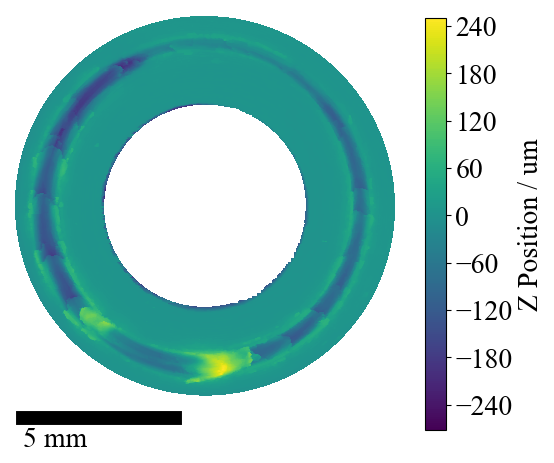

Time elapsed:  26.581084966659546  seconds


In [36]:
#------------#------------#
#Combine both pairs of data
#------------#------------#
start_time = time.time()


def load_data(saving_file_name):
# Load data from HDF5 file
    with h5py.File(saving_file_name, 'r') as f:
        X = f['X_new'][:]
        Y = f['Y_new'][:]
        pixel_size = f.attrs['pixel_size']
        data = pd.DataFrame(f['translated_data'][:])
        raw = pd.DataFrame(f['raw_data'][:])
        tilted_data = pd.DataFrame(f['tilted_data_3'][:])

# Resolution
    X_res = X[1] - X[0] # mm
    Y_res = Y[1] - Y[0] # mm
    mean_res = (X_res + Y_res)/2 # mm
    
# Generate z_clean
    z_clean = data.to_numpy().flatten()[~np.isnan(data.to_numpy().flatten())]
# Generate Z_sort
    Z_sort_nan = np.sort(np.ndarray.flatten(np.asarray(data))) #Flattening the dataframe into a 1D array & ordering (doesn't matter but easy to do)
    Z_sort = Z_sort_nan[~np.isnan(Z_sort_nan)] #Removing the NaN cells (enabling further operations to be performed), -ve sign to remove NaN
    
    return X, Y, pixel_size, data, X_res, Y_res


def plot_data(X, Y, data):
    # Create a figure and axis object
    fig, ax = plt.subplots()

# Create a filled contour plot
    norm = TwoSlopeNorm(vmin=data.min().min(), vcenter=0, vmax=data.max().max())
    contour = ax.contourf(X, Y, data, 256, norm=norm)

# Set axis to be equal
    ax.set_aspect('equal')

# Add a colorbar
    cbar = fig.colorbar(contour, ax=ax, shrink=0.85)
    cbar.set_label('Z Position / um', fontsize=plot_font_size)

# Use MaxNLocator to determine suitable ticks
    cbar.locator = MaxNLocator(nbins=10)
    cbar.update_ticks()

    cbar.ax.tick_params(labelsize=plot_font_size)

# Set color limits
    contour.set_clim(vmax=np.amax(data.max()), vmin=np.amin(data.min()))

# Turn off ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove all spines
    ax.spines["top"].set_visible(cap)
    ax.spines["right"].set_visible(cap)
    ax.spines["bottom"].set_visible(cap)
    ax.spines["left"].set_visible(cap)

# Add a scale bar of 10mm in the bottom left corner
    scalebar_length = 5 #mm
    x_pos = -6
    y_pos = -7
    ax.plot([x_pos, x_pos + scalebar_length], [y_pos, y_pos], color='black', lw=10)  # Thicker scale bar
    ax.text(x_pos, y_pos - 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), '5 mm', fontsize=plot_font_size, va='top')

# Resize the plot area
    fig.set_size_inches(160/25.4, 160/25.4)

    #output = sample_1_pre_test_name.replace('.xyz', '_circle_scalebar.png')
    #fig.savefig(output, dpi=150)

# Show the plot
    plt.show()



#Load sample 1
X_1, Y_1, pixel_size_1, data_1, X_res_1, Y_res_1 = load_data(saving_sample_1_post_test_name)
#Y_1, X_1, pixel_size_1, data_1, Y_res_1, X_res_1 = load_data(saving_sample_1_post_test_name)
#data_1 = data_1.iloc[::-1, ::-1].T # correctly orient data
data_1 = data_1.iloc[::-1]
yap("X1: ", np.shape(X_1), " Y1: ", np.shape(Y_1), " data_1: ", np.shape(data_1))

#Load sample 2
X_2, Y_2, pixel_size_2, data_2, X_res_2, Y_res_2 = load_data(saving_sample_2_post_test_name)
yap("X2: ", np.shape(X_2), " Y2: ", np.shape(Y_2), " data_2: ", np.shape(data_2))


## In order to get any meaning out of the stacked data they must be aligned to how the test stopped
# which requires knowning the ending rotation angle 
# and be able to rotate the data set by that angle (really hard to do)


# Set X and Y

if max(X_1) >= max(X_2):
    X_stacked = X_1
else:
    X_stacked = X_2
    
if max(Y_1) >= max(Y_2):
    Y_stacked = Y_1
else:
    Y_stacked = Y_2

    
#distort to align centres and edges
X0_1 = np.where(X_1 == 0)[0]
Y0_1 = np.where(Y_1 == 0)[0]
X0_2 = np.where(X_2 == 0)[0]
Y0_2 = np.where(Y_2 == 0)[0]
row_padding = Y0_1 - Y0_2
col_padding = X0_1 - X0_2


# Actual Stack Data
stacked_data = pd.DataFrame(data_1.to_numpy()) + pd.DataFrame(data_2.to_numpy()) #need to convert to number to remove indexing to alloy correct data flipping, need dataframe for addition
yap("stacked data: ", np.shape(stacked_data))

plot_data(X_stacked, Y_stacked, stacked_data)

# Galled Binary Stack Data


# Trough Binary Stack Data

# Peak Binary Stack Data


end_time = time.time()
yap('Time elapsed: ', end_time - start_time, ' seconds')

# Basic visualisation of the data

In [28]:
#------------#------------#
# Load for File Visualisation
#------------#------------#

start_time = time.time()

vis_file_name = saving_sample_1_post_test_name

# Load data from HDF5 file
with h5py.File(vis_file_name, 'r') as f:
    X = f['X_new'][:]
    Y = f['Y_new'][:]
    pixel_size = f.attrs['pixel_size']
    data = pd.DataFrame(f['translated_data'][:])
    raw = pd.DataFrame(f['raw_data'][:])
    tilted_data = pd.DataFrame(f['tilted_data_3'][:])
    
    

In [ ]:

#------------#------------#
# Compare Raw Data and Processed Data
#------------#------------#

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data on the first subplot
c1 = ax[0].contourf(X, Y, raw, 256, vmin=np.amin(raw), vmax=np.amax(raw))
ax[0].set_title('Original Data')
ax[0].axis('equal')
fig.colorbar(c1, ax=ax[0], ticks=range(-800, -100, 100), label='Z Position / um')
c1.set_clim(vmax=np.amax(raw), vmin=np.amin(raw))
ax[0].set_xlabel('X Position / mm')
ax[0].set_ylabel('Y Position / mm')
ax[0].spines["top"].set_visible(cap)
ax[0].spines["right"].set_visible(cap)

# Plot the corrected data on the second subplot
norm_cor = TwoSlopeNorm(vmin=np.amin(data), vcenter=0, vmax=np.amax(data))
c2 = ax[1].contourf(X, Y, data, 256, norm=norm_cor)
ax[1].set_title('Corrected Data')
ax[1].axis('equal')
fig.colorbar(c2, ax=ax[1], ticks=range(-500, 500, 50), label='Z Position / um')
c2.set_clim(vmax=np.amax(data), vmin=np.amin(data))
ax[1].set_xlabel('X Position / mm')
ax[1].set_ylabel('Y Position / mm')
ax[1].spines["top"].set_visible(cap)
ax[1].spines["right"].set_visible(cap)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) # Spread out graphs to avoid overlap

# Resizing the plot area
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12 # X-axis size
fig_size[1] = 12 # Y-axis size

plt.show()

end_time = time.time()
yap('Time elapsed: ', end_time - start_time, ' seconds')

#### Top down

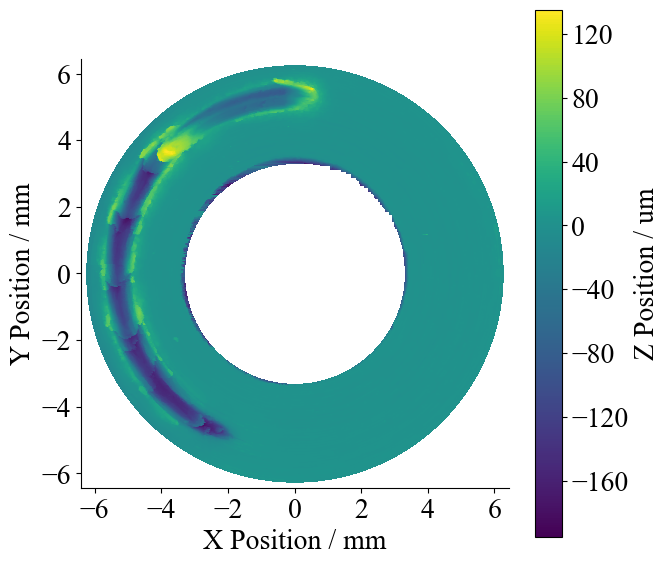

Total execution time: 26.44 seconds


In [29]:
# Creates a top down 2D plot

# Start timing
start_time = time.time()

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a filled contour plot
norm = TwoSlopeNorm(vmin=data.min().min(), vcenter=0, vmax=data.max().max())
contour = ax.contourf(X, Y, data, 256, norm=norm )

# Set the title
# ax.set_title('Corrected Data')

# Set axis to be equal
ax.set_aspect('equal')

# Add a colorbar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Z Position / um', fontsize = plot_font_size)

# Use MaxNLocator to determine suitable ticks
cbar.locator = MaxNLocator(nbins=10)  # Increase the number of bins for more ticks
cbar.update_ticks()

cbar.ax.tick_params(labelsize = plot_font_size) 

# Alternatively, you can set custom ticks manually
# cbar.set_ticks(np.linspace(np.amin(data.min()), np.amax(data.max()), num=15))

# Set color limits (again, this may be redundant but included for consistency)
contour.set_clim(vmax=np.amax(data.max()), vmin=np.amin(data.min()))

# Label the axes
ax.set_xlabel('X Position / mm', fontsize = plot_font_size)
plt.xticks(fontsize = plot_font_size)                  
ax.set_ylabel('Y Position / mm', fontsize = plot_font_size)
plt.yticks(fontsize = plot_font_size)                  

# Remove the top and right spines
ax.spines["top"].set_visible(cap)
ax.spines["right"].set_visible(cap)

# Adjust the layout to avoid overlap
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Resize the plot area
fig.set_size_inches(160/25.4, 160/25.4)

output = vis_file_name.replace('.h5', '_circle.png')
fig.savefig(output, dpi=150)

# Show the plot
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

#### Using a scale bar instead of tick marks

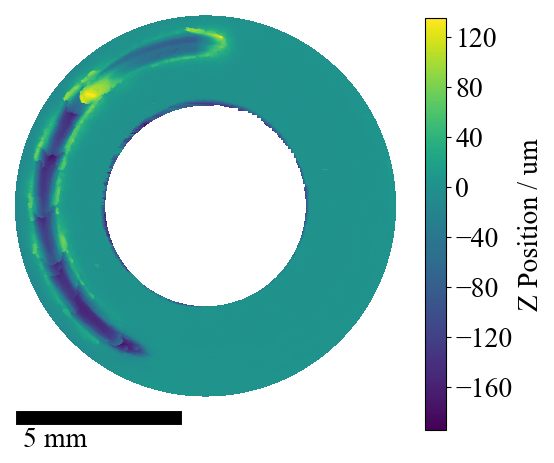

Total execution time: 24.44 seconds


In [82]:
# Start timing
start_time = time.time()

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a filled contour plot
norm = TwoSlopeNorm(vmin=data.min().min(), vcenter=0, vmax=data.max().max())
contour = ax.contourf(X, Y, data, 256, norm=norm)

# Set axis to be equal
ax.set_aspect('equal')

# Add a colorbar
cbar = fig.colorbar(contour, ax=ax, shrink=0.85)
cbar.set_label('Z Position / um', fontsize=plot_font_size)

# Use MaxNLocator to determine suitable ticks
cbar.locator = MaxNLocator(nbins=10)
cbar.update_ticks()

cbar.ax.tick_params(labelsize=plot_font_size)

# Set color limits
contour.set_clim(vmax=np.amax(data.max()), vmin=np.amin(data.min()))

# Turn off ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Remove all spines
ax.spines["top"].set_visible(cap)
ax.spines["right"].set_visible(cap)
ax.spines["bottom"].set_visible(cap)
ax.spines["left"].set_visible(cap)

# Add a scale bar of 10mm in the bottom left corner
scalebar_length = 5 #mm
x_pos = -6
y_pos = -7
ax.plot([x_pos, x_pos + scalebar_length], [y_pos, y_pos], color='black', lw=10)  # Thicker scale bar
ax.text(x_pos, y_pos - 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), '5 mm', fontsize=plot_font_size, va='top')

# Resize the plot area
fig.set_size_inches(160/25.4, 160/25.4)

output = vis_file_name.replace('.h5', '_circle_scalebar.png')
fig.savefig(output, dpi=150)

# Show the plot
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

#### Side on

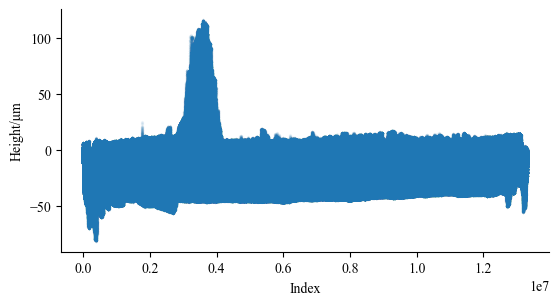

Total execution time: 5.71 seconds


In [9]:
# Creates a side on 2D plot

# Start timing
start_time = time.time()

z_clean = data.to_numpy().flatten()[~np.isnan(data.to_numpy().flatten())]

# Generate X values as indices
x_values = np.arange(len(z_clean))

# Create the plot
plt.figure(figsize=(160/25.4, 80/25.4))
plt.scatter(x_values, z_clean, alpha = 0.05, s = 2)
plt.xlabel('Index')
plt.ylabel('Height/μm')
output = vis_file_name.replace('.h5', '_2D.png')


# Remove top and right spines
plt.gca().spines['top'].set_visible(cap)
plt.gca().spines['right'].set_visible(cap)

plt.savefig('2ndtilt_slice', dpi=150)

plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

# This code quantifies surface roughness

#### This code finds the Root mean square of the surface

In [ ]:
# Calculate the mean
mean_value = np.mean(z_clean)
yap(f"Mean of the array: {mean_value:.4g} µm")

# Calculate squared differences from the mean
squared_differences = np.square(z_clean - mean_value)
yap("Squared differences from the mean:", squared_differences)

# Calculate the mean of the squared differences
mean_of_squared_differences = np.mean(squared_differences)
yap(f"Mean of the squared differences: {mean_of_squared_differences:.4g} µm²")

# Calculate the RMS value
rms_value = np.sqrt(mean_of_squared_differences)
yap(f"The RMS value of the 2D array is: {rms_value:.4g} µm")

#### This code uses threshold from mean

In [ ]:
# Set a threshold range around the mean (which is now 0)
threshold = 6  # Adjust this value to your needs

# Start timing
start_time = time.time()

sorted_values = np.sort(z_clean)

# Calculate the mean
mean_value = sorted_values.mean()

# Shift the data so that the mean is at 0
shifted_values = sorted_values - mean_value

# Recalculate cumulative counts
cumulative_counts = np.arange(1, len(shifted_values) + 1)
# Convert counts to normalized percentages
percentage_below = cumulative_counts / len(shifted_values)

lower_bound = -threshold
upper_bound = threshold

# --- The range is picked -----------------------------------------------------------------------------------------------------------------------------------------------------

# Filter values outside the acceptable range
below_lower_bound_values = shifted_values[shifted_values < lower_bound]
above_upper_bound_values = shifted_values[shifted_values > upper_bound]

# Calculate how many points are outside the acceptable range
points_below_lower_bound = len(below_lower_bound_values)
points_above_upper_bound = len(above_upper_bound_values)

percentage_below_lower_bound = points_below_lower_bound / len(shifted_values) * 100
percentage_above_upper_bound = points_above_upper_bound / len(shifted_values) * 100

# Volume calculation for points in mm^3
volumes_below_lower_bound = np.sum(below_lower_bound_values/1000 * pixel_size)
volumes_above_upper_bound = np.sum(above_upper_bound_values/1000 * pixel_size)

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing

# Plot the cumulative frequency distribution
plt.figure(figsize=(12, 6))
plt.plot(percentage_below, shifted_values)

# Plot the values outside the acceptable range
plt.plot(percentage_below[np.searchsorted(shifted_values, lower_bound)], lower_bound, 'ro', label=f'Lower Bound ({lower_bound:.2f})')
plt.plot(percentage_below[np.searchsorted(shifted_values, upper_bound)], upper_bound, 'bo', label=f'Upper Bound ({upper_bound:.2f})')

# Plot the shifted mean point (now zero)
plt.plot(percentage_below[np.searchsorted(shifted_values, 0)], 0, 'go', label=f'Zero-plane and mean (0)')

# Remove top and right spines
plt.gca().spines['top'].set_visible(cap)
plt.gca().spines['right'].set_visible(cap)

# Add labels and title
plt.xlabel('Cumulative Frequency')
plt.ylabel('Height/um')
plt.legend(frameon=0)
plt.tight_layout
plt.savefig('mean.png', dpi = 150)
plt.show()

# Print the results
yap(f'Below lower bound: {points_below_lower_bound} points, with an area of {points_below_lower_bound * pixel_size:.4g} mm² ({percentage_below_lower_bound:.2f}% of points)')
yap(f'Above upper bound: {points_above_upper_bound} points, with an area of {points_above_upper_bound * pixel_size:.4g} mm² ({percentage_above_upper_bound:.2f}% of points)')
yap('\n')
# Print percentages relative to the sample area
yap(f'Using calculated area of sample to be {SA:.4g} mm²')
yap(f'Below lower bound: {points_below_lower_bound * pixel_size / SA * 100:.4g}%')
yap(f'Above upper bound: {points_above_upper_bound * pixel_size / SA * 100:.4g}%')
yap('\n')
# Print volumn of peak and trough in mm^3
yap(f'Trough volume of {abs(volumes_below_lower_bound):.4g} mm³')
yap(f'Peak volume of {volumes_above_upper_bound:.4g} mm³')
yap(f'Total galled volume of {abs(volumes_below_lower_bound) + volumes_above_upper_bound:.4g} mm³')
yap('\n')

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

#### This code uses threshold from median (zero-plane)

In [83]:
# Set a threshold range around the median
threshold = 6  # Adjust this value to your needs

# Start timing
start_time = time.time()

sorted_values = np.sort(z_clean)

# Recalculate cumulative counts
cumulative_counts = np.arange(1, len(sorted_values) + 1)
# Convert counts to normalized percentages
percentage_below = cumulative_counts / len(sorted_values)

lower_bound = -threshold
upper_bound = threshold

# --- The range is picked -----------------------------------------------------------------------------------------------------------------------------------------------------

# Filter values outside the acceptable range
below_lower_bound_values = shifted_values[sorted_values < lower_bound]
above_upper_bound_values = shifted_values[sorted_values > upper_bound]

# Calculate how many points are outside the acceptable range
points_below_lower_bound = len(below_lower_bound_values)
points_above_upper_bound = len(above_upper_bound_values)

percentage_below_lower_bound = points_below_lower_bound / len(sorted_values) * 100
percentage_above_upper_bound = points_above_upper_bound / len(sorted_values) * 100

# Volume calculation for points in mm^3
volumes_below_lower_bound = np.sum(below_lower_bound_values/1000 * pixel_size)
volumes_above_upper_bound = np.sum(above_upper_bound_values/1000 * pixel_size)

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing


# Plot the cumulative frequency distribution
plt.figure(figsize=(12, 6))
plt.plot(percentage_below, sorted_values)

# Plot the values outside the acceptable range
plt.plot(percentage_below[np.searchsorted(sorted_values, lower_bound)], lower_bound, 'ro', label=f'Lower Bound ({lower_bound:.2f})')
plt.plot(percentage_below[np.searchsorted(sorted_values, upper_bound)], upper_bound, 'bo', label=f'Upper Bound ({upper_bound:.2f})')

# Plot the shifted mean point (now zero)
plt.plot(percentage_below[np.searchsorted(sorted_values, 0)], 0, 'go', label=f'Zero plane (0)')

# Remove top and right spines
plt.gca().spines['top'].set_visible(cap)
plt.gca().spines['right'].set_visible(cap)

# Add labels and title
plt.xlabel('Cumulative Frequency')
plt.ylabel('Height/um')
plt.legend(frameon=0)
plt.tight_layout
plt.savefig('median.png', dpi = 150)
plt.show()

# Print the results
yap(f'Below lower bound: {points_below_lower_bound} points, with an area of {points_below_lower_bound * pixel_size:.4g} mm² ({percentage_below_lower_bound:.2f}% of points)')
yap(f'Above upper bound: {points_above_upper_bound} points, with an area of {points_above_upper_bound * pixel_size:.4g} mm² ({percentage_above_upper_bound:.2f}% of points)')
yap('\n')
# Print percentages relative to the sample area
yap(f'Using calculated area of sample to be {SA:.4g} mm²')
yap(f'Below lower bound: {points_below_lower_bound * pixel_size / SA * 100:.4g}%')
yap(f'Above upper bound: {points_above_upper_bound * pixel_size / SA * 100:.4g}%')
yap('\n')
# Print volumn of peak and trough in mm^3
yap(f'Trough volume of {abs(volumes_below_lower_bound):.4g} mm³')
yap(f'Peak volume of {volumes_above_upper_bound:.4g} mm³')
yap(f'Total galled volume of {abs(volumes_below_lower_bound) + volumes_above_upper_bound:.4g} mm³')
yap('\n')
# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

NameError: name 'z_clean' is not defined

# This code helps visualize tilt correction

In [ ]:
# Start timing
start_time = time.time()

data = raw_data.to_numpy()

# Flatten the array to get all Z values
z_values = data.flatten()

# Generate X values as indices
x_values = np.arange(len(z_values))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, z_values, alpha = 0.05, s = 2, color = "tab:orange")
plt.xlabel('Index')
plt.ylabel('Height/μm')
output = sample_1_pre_test_name.replace('.xyz', '_2D.png')
plt.savefig('raw_Data.png', dpi=150)
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

In [ ]:
# Start timing
start_time = time.time()

data = tilted_data3.to_numpy()

# Flatten the array to get all Z values
z_values = data.flatten()

# Generate X values as indices
x_values = np.arange(len(z_values))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, z_values, alpha = 0.05, s = 2, color = "tab:green")
plt.xlabel('Index')
plt.ylabel('Height/μm')
output = sample_1_pre_test_name.replace('.xyz', '_2D.png')
plt.savefig('1st_tilt.png', dpi=150)
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

In [ ]:
start_time = time.time()

# Example of how you might have multiple dataframes (replace this with your actual setup)
dataframes = [raw_data, tilted_data3, ELIYXTT]
labels = ['raw_data', 'tilted_data3', 'ELIYXTT']
colors = ['tab:orange', 'tab:green', 'tab:blue']

plt.figure(figsize=(160/25.4, 80/25.4))

# Iterate over each dataframe
for idx, df in enumerate(dataframes):
    # Convert dataframe to numpy array outside the loop
    #yap(type(data))
    #data = data.to_numpy()
    
    # Flatten the array to get all Z values
    z_values = data.flatten()

    # Downsample the data to speed up plotting, e.g., plot every 10th point
    if idx == 0:
        step = 2
    else:
        step = 10  # Change step size based on your dataset
    
    x_values = np.arange(len(z_values))[::step]
    z_values = z_values[::step]

    # Create the plot for each dataframe
    plt.scatter(x_values, z_values, alpha=0.2, s=1, label=labels[idx], color=colors[idx])

plt.xlabel('Index')
plt.ylabel('Z')
legend = plt.legend(loc= 1,frameon=cap)

for handle in legend.legendHandles:
    handle.set_alpha(1)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(cap)
plt.gca().spines['right'].set_visible(cap)

# Save the figure
plt.savefig('allstakced.png', dpi=150)

plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

#### This is so dumb but look at it (3D spinning gif)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import time

# Start timing
start_time = time.time()

# Set figure size to 1920x1080 resolution with 300 DPI
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Parameters
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 2 * np.pi, 50)
u, v = np.meshgrid(u, v)

# Create the 3D contour plot
contour = ax.contour3D(Xnew, Ynew, ELIYXTT, 150, cmap='viridis', vmax=np.amax(ELIYXTT), vmin=np.amin(ELIYXTT))

# Remove gridlines, axis, and background
ax.grid(cap)
ax.set_axis_off()

# Animation function to update view angle (top-down and rotating around y-axis)
def update(frame):
    ax.view_init(elev=frame % 360, azim=0)  # Elevation fixed (side view), changing azimuth to simulate left-to-right flipping
    return fig,

# Create animation
frames = 360  # Full rotation over 360 frames
anim = FuncAnimation(fig, update, frames=frames, interval=1000/120)

# Save as GIF
anim.save('spinning_donut.gif', writer=PillowWriter(fps=60))

plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

#### 3D (not currently saved as image)

In [ ]:
# Creates a fun 3D plot

# Start timing
start_time = time.time()

# Create a figure and an axes for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D contour plot
contour = ax.contour3D(Xnew, Ynew, ELIYXTT, 150, cmap='viridis', vmax=np.amax(ELIYXTT), vmin=np.amin(ELIYXTT))

# Labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('ELIYXTT')

# Show the plot
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
yap(f"Total execution time: {end_time - start_time:.2f} seconds")

# This is Sams old galling area code, im keeping here because its good to check the code outputs the same numbers

In [ ]:
#Finding the galled area and displaced volumes using the Cumulative Frequency Distribution
Ra = 6 #Ra in um

Zsortnan = np.sort(np.ndarray.flatten(np.asarray(ELIYXTT)))
Zsort = Zsortnan[~np.isnan(Zsortnan)]

#Size of each pixel for corrected sample
Xnewsize = 0.003484/(XTilt1*XTilt2*XTilt3)
Ynewsize = 0.003484/(YTilt1*YTilt2*YTilt3)

for i in range(0, len(Zsort), 1):
    if Zsort[i]>-Ra:
        ineg = i
        yap('ineg: ', ineg)
        break
    else:
        continue
    
    
for i in range(ineg, len(Zsort), 1):
    if Zsort[i]>Ra:
        ipos = i
        yap('ipos: ', ipos)
        break
    else:
        continue

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing

if 100*Xnewsize*Ynewsize*(ineg+(len(Zsort)-ipos))/SA <= 0:
    GA = 0
else:
    GA = 100*Xnewsize*Ynewsize*(ineg+(len(Zsort)-ipos))/SA

if ineg==0:
    DVneg = 0
else:
    DVneg = -np.sum(Zsort[0:ineg-1])*Xnewsize*Ynewsize/1000
    
DVpos = np.sum(Zsort[ipos:])*Xnewsize*Ynewsize/1000
DVtot = DVneg + DVpos

TGA = 100*Xnewsize*Ynewsize*(ineg)/SA
PGA = 100*Xnewsize*Ynewsize*((len(Zsort)-ipos))/SA

yap('List length:',len(Zsort))
yap('Trough Area / %: ', TGA)
yap('Peak Area / %: ', PGA)
yap('Galled Area / %: ', GA)
yap()
yap('Trough Volume (mm3): ', DVneg)
yap('Peak Volume (mm3): ', DVpos)
yap('Total Galled Volume (mm3): ', DVtot)
yap()
yap('Xszie,Ysize:',Xnewsize*Ynewsize)
yap('Pixel size:',pixel_size)
yap('surafce area:',SA)